<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Franco Urrutia Ghiardo</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>

## 1. Carga de Datos


In [ ]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time

#cargar una imagen y convertirla a escala de grises
def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Error al cargar la imagen en la ruta: {path}")
    return image

zip_file = r'D:\Proyecto2\imagenes.zip'
extract_folder = r'D:\Proyecto2\'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Archivos extraídos en: {extract_folder}")

# Cargar las plantillas
circle_template_path = r'D:\Proyecto2\circ_template.png'
box_template_path = r'D:\Proyecto2\box_template.png'
cross_template_path = r'D:\Proyecto2\cross_template.png'

circle_template = load_image(circle_template_path)
box_template = load_image(box_template_path)
cross_template = load_image(cross_template_path)


Archivos extraídos en: D:\Proyecto2\processed512


## 2. Transformar imagen


In [ ]:
# Función para preprocesar la imagen y la plantilla
def preprocesar(image):
    filtered_image = cv2.bilateralFilter(image, 1, 75, 50) #filtro bilateral para mejorar botdes y reducir ruido
    binary_image = cv2.adaptiveThreshold(filtered_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 15) #binarizado de la imagen
    return binary_image


## 3. Operaciones


In [ ]:
dividir la imagen en 4 cuadrantes
def definir_cuadrantes(image):
    alto, ancho = image.shape[:2]
    mitad_alto = alto // 2
    mitadd_ancho = ancho // 2
    cuadrantes = {
        "top_left": image[:mitad_alto, :mitadd_ancho],
        "top_right": image[:mitad_alto, mitadd_ancho:],
        "bottom_right": image[mitad_alto:, mitadd_ancho:],
        "bottom_left": image[mitad_alto:, :mitadd_ancho]
    }
    return cuadrantes

# rotar la plantilla según  cuadrante
def rotar(template, angulo):
    template_rotada = template
    if angulo == 90:
        template_rotada = cv2.rotate(template, cv2.ROTATE_90_CLOCKWISE)
    elif angulo == 180:
        template_rotada = cv2.rotate(template, cv2.ROTATE_180)
    elif angulo == 270:
        template_rotada = cv2.rotate(template, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return template_rotada


## 4. Matching


In [ ]:
#  realizar la correlación cruzada normalizada
def normalized_cross_correlation(image, template):
    result = cv2.matchTemplate(image, template, cv2.TM_CCORR_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    return max_loc, max_val, result

# Procesamiento de las imágenes
folder_path = r'D:\Proyecto2\processed512'
results = []

# Inicializar matriz de confusión
confusion_matrix = {
    "box": {"box": 0, "circ": 0, "cross": 0},
    "circ": {"box": 0, "circ": 0, "cross": 0},
    "cross": {"box": 0, "circ": 0, "cross": 0}
}

start_time = time.time()

# Iterar sobre cada imagen en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        image_path = os.path.join(folder_path, filename)

        # Cargar la imagen
        image = load_image(image_path)

        # Extraer etiquetas del nombre del archivo
        parts = filename.split('_')
        template_type = parts[0]  # box, circ, cross
        unique_id = parts[2]  # identificador

        # Obtener los cuadrantes de la imagen
        quadrants = get_quadrants(image)

        # Preprocesar los cuadrantes y las plantillas
        prepo_cuad = {name: preeprocesar(quadrant) for name, quadrant in quadrants.items()}
        prepro_circ_temp = preeprocesar(circle_template)
        prepro_box_temp = preeprocesar(box_template)
        prepro_cross_temp = preeprocesar(cross_template)

        # Definir las rotaciones necesarias para cada cuadrante
        rotations = {
            "top_left": 0,
            "top_right": 90,
            "bottom_right": 180,
            "bottom_left": 270
        }

        # Inicializar variables para acumular las correlaciones
        sum_circle_correlation = 0
        sum_box_correlation = 0
        sum_cross_correlation = 0
        num_quadrants = 0

        # Evaluar cada cuadrante con la plantilla correspondiente
        for quadrant_name, quadrant in prepo_cuad.items():
            angle = rotations[quadrant_name]

            rotated_circle_template = rotate_template(prepro_circ_temp, angle)
            rotated_box_template = rotate_template(prepro_box_temp, angle)
            rotated_cross_template = rotate_template(prepro_cross_temp, angle)


            circle_loc, circle_val, circle_result = normalized_cross_correlation(quadrant, rotated_circle_template)
            box_loc, box_val, box_result = normalized_cross_correlation(quadrant, rotated_box_template)
            cross_loc, cross_val, cross_result = normalized_cross_correlation(quadrant, rotated_cross_template)

                # Acumular las correlaciones
            sum_circle_correlation += circle_val
            sum_box_correlation += box_val
            sum_cross_correlation += cross_val
            num_quadrants += 1


        # Calcular el promedio de correlaciones para esta imagen
        avg_circle_correlation = sum_circle_correlation / num_quadrants if num_quadrants > 0 else 0
        avg_box_correlation = sum_box_correlation / num_quadrants if num_quadrants > 0 else 0
        avg_cross_correlation = sum_cross_correlation / num_quadrants if num_quadrants > 0 else 0

        # Determinar la etiqueta predicha (plantilla con la correlación máxima)
        predicted_label = None
        if avg_circle_correlation > avg_box_correlation and avg_circle_correlation > avg_cross_correlation:
            predicted_label = "circ"
        elif avg_box_correlation > avg_circle_correlation and avg_box_correlation > avg_cross_correlation:
            predicted_label = "box"
        elif avg_cross_correlation > avg_circle_correlation and avg_cross_correlation > avg_box_correlation:
            predicted_label = "cross"

        # Almacenar los resultados en la lista
        results.append({
            "Imagen": filename,
            "Tipo Plantilla": template_type,
            "ID Único": unique_id,
            "Circle - Avg NCC": avg_circle_correlation,
            "Box - Avg NCC": avg_box_correlation,
            "Cross - Avg NCC": avg_cross_correlation,
            "Predicción": predicted_label
        })

        # Actualizar matriz de confusión
        confusion_matrix[template_type][predicted_label] += 1



# Fin de la medición de tiempo
end_time = time.time()
print(f"Tiempo total de procesamiento: {end_time - start_time} segundos")


Tiempo total de procesamiento: 161.67415690422058 segundos


## 5. Clasificación


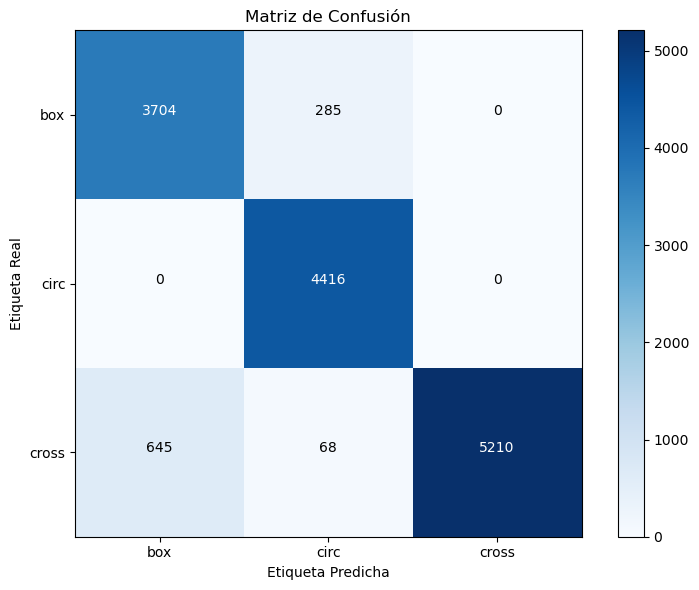

In [ ]:
# Obtener etiquetas y valores de la matriz de confusión
labels = list(confusion_matrix.keys())
values = np.array([[confusion_matrix[label][pred] for pred in confusion_matrix[label]] for label in labels])

# Generar y guardar la imagen de la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(values, interpolation='nearest', cmap=plt.cm.Blues)

# Anotar cada celda con el valor correspondiente
for i, j in itertools.product(range(values.shape[0]), range(values.shape[1])):
    plt.text(j, i, format(values[i, j], 'd'),
             horizontalalignment="center",
             color="white" if values[i, j] > values.max() / 2. else "black")

plt.title('Matriz de Confusión')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.savefig('matriz_confusion.png', dpi=300)
plt.show()


## 6. Medición



Ejemplos Bien Identificados:


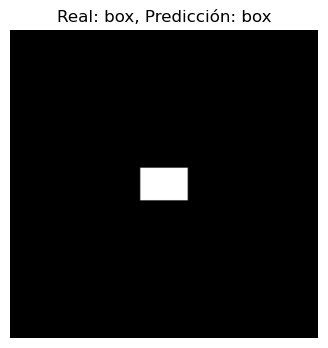

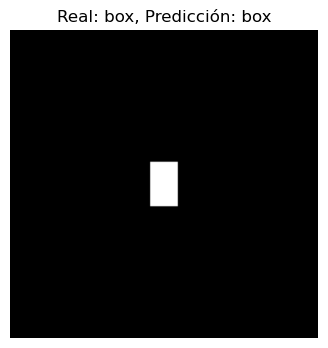


Ejemplos Mal Identificados:


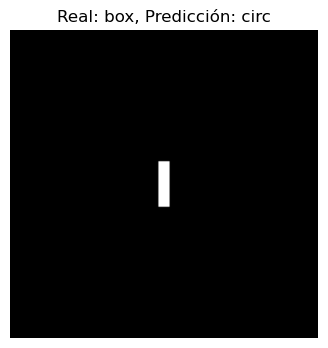

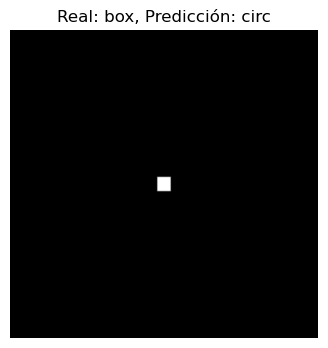

In [ ]:
# Mostrar ejemplos bien identificados y mal identificados
correctos = []
incorrectos = []

for result in results:
    real_label = result["Tipo Plantilla"]
    predicted_label = result["Predicción"]
    if real_label == predicted_label:
        correctos.append(result)
    else:
        incorrectos.append(result)

print("\nEjemplos Bien Identificados:")
for i, example in enumerate(correctos[:2]):
    image_path = os.path.join(folder_path, example["Imagen"])
    image = load_image(image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.title(f"Real: {example['Tipo Plantilla']}, Predicción: {example['Predicción']}")
    plt.axis('off')
    plt.show()

print("\nEjemplos Mal Identificados:")
for i, example in enumerate(incorrectos[:2]):
    image_path = os.path.join(folder_path, example["Imagen"])
    image = load_image(image_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.title(f"Real: {example['Tipo Plantilla']}, Predicción: {example['Predicción']}")
    plt.axis('off')
    plt.show()
